# 10. 画像処理分野

## 概要

本演習では ResNet の Residual Block を穴埋め形式で実装します。

なお、予め用意されたコードはそのまま使用し、指示された穴埋め部を編集してください。  
演習問題文は<font color="Red">赤字</font>です。

また、乱数設定により実行結果が異なるため、<font color="Red">コードを完成させたあと、必ずもう一度一番上のセルから順に最後まで実行して結果を確認してください。</font>

所要時間：<font color="Red">5~8時間</font>

### ライブラリのインポート

必要なライブラリのインストールを行います。

In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.models import resnet50, wide_resnet50_2

try:
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm_notebook as tqdm
    
np.random.seed(1)
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1)
    torch.backends.cudnn.benchmark = True

# GPU が利用できる場合は、GPU上で学習を行います。
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### データセットの準備

データセットには、cifar10 を使用します。

cifar10 は10種類のクラスを含まれており、  
学習データ 50000枚、テストデータ 10000枚で構成されています。

データは 3チャンネル(RGB)の縦横 32×32 の配列`(3, 32, 32)`となっています。

本演習では実行時間の関係上、飛行機と自動車の画像500枚ずつに限定して学習します。

In [ ]:
# 画像データを標準化する際の平均と分散、およびバッチサイズ
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 8

# 学習データに適用する前処理
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),   # 短い辺の長さがresizeの大きさになる
    transforms.RandomHorizontalFlip(),          # ランダムに左右に反転する
    transforms.ToTensor(),                      # Torchテンソルに変換
    transforms.Normalize(mean, std)             # 色情報の標準化
])
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=train_transform
)

num_data = 500
num_classes = 2

# 学習データから飛行機と自動車の画像を抽出
mini_data = [[] for x in range(num_classes)]
idx_list = list(range(2))
for img, tgt in zip(trainset.data, trainset.targets):
    if tgt in idx_list and len(mini_data[tgt]) < num_data:
        mini_data[tgt].append(img)
mini_data = np.array(mini_data, dtype=trainset.data.dtype).reshape(-1, 32, 32, 3)

 #学習データ用の正解ラベルを作成
mini_targets = []
for i in idx_list:
    tgt = [i] * num_data
    mini_targets += tgt
  
 #学習データの置き換え
trainset.data = mini_data
trainset.targets = mini_targets

# 学習データのデータローダ
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size,
    shuffle=True, num_workers=2
)

# テストデータに適用する前処理
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # 短い辺の長さがresizeの大きさになる
    transforms.ToTensor(),              # Torchテンソルに変換
    transforms.Normalize(mean, std)     # 色情報の標準化
])
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform=test_transform
)

# テストデータから飛行機と自動車の画像を抽出
mini_data = [[] for x in range(num_classes)]
for img, tgt in zip(testset.data, testset.targets):
    if tgt in idx_list:
        mini_data[tgt].append(img)
mini_data = np.array(mini_data, dtype=testset.data.dtype).reshape(-1, 32, 32, 3)

# テストデータ用の正解ラベルを作成
mini_targets = []
for i in idx_list:
    tgt = [i] * 1000
    mini_targets += tgt

# テストデータの置き換え
testset.data = mini_data
testset.targets = mini_targets

# テストデータのデータローダ
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size,
    shuffle=False, num_workers=2
)

#### データセットの確認  
以上のようにして変数 `trainloader`、`testloader` へ格納したデータの中身を確認します。

これらは Dataloader であるため、配列のように取り出すことができません。  
詳細は chapter04 にて説明されています。

今回の Dataloader は1次元目の第1要素`[0]`に各画像データを、第2要素`[1]`にラベルデータを持ち、画像データとラベルデータで以降の次元の形状が異なります。

In [3]:
# 各バッチに対応するオブジェクトの集合体tmpを取得
tmp = trainloader.__iter__()
# バッチごとにデータを取り出す
batch1 = next(tmp)

# データとラベルに分割
data = np.array(batch1[0])
label = np.array(batch1[1])
print("画像データの形状：　　　", data.shape)
print("ラベルデータの形状：", label.shape)

画像データの形状：　　　 (8, 3, 224, 224)
ラベルデータの形状： (8,)


__画像データ__  

画像データの形状は [ バッチ内の画像数`N`, チャンネル`C`, 縦pixel数`H`, 横pixel数`W` ] の四次元です。  
バッチ内の画像数 `N` はデータセットに対し `torch.utils.data.DataLoader()` を適用した際に引数 `batch_size` によって定められた枚数となります。  
cifar10 の画像サイズは 32×32 ですが、こちらも `transforms.Compose()` による前処理の段階でリサイズされているため上記のような値となっています。


__ラベルデータ__  

ラベルデータの形状は [ バッチ内の画像数`N` ] の一次元です。  
同様のインデックスを持つ画像データのラベルが格納されており、今回は飛行機 `0` と自動車 `1` と割り振られています。

In [4]:
label   # バッチ内の画像8枚のラベル

array([1, 0, 0, 0, 1, 0, 0, 1])

画像として出力し、cifar10 のデータ内容を確認します。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


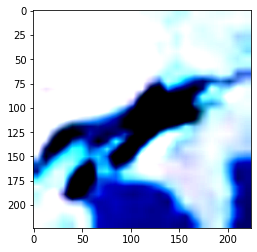

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  0


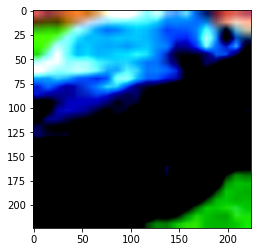

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  1


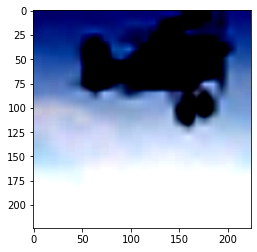

Label:  0


In [5]:
import matplotlib.pyplot as plt

for i in range(3):
  img = data[i]
  img= img.transpose(1, 2, 0)    # 配列を [縦, 横, RGB] に変更
  plt.imshow(img)                 # 表示
  plt.show()
  print( 'Label: ', label[i] )

## 1. ResNetを用いたCIFAR10の分類

### ResNetについて

CNNでは多層化することでネットワークの表現能力が向上することが知られているが、同時に入力層付近で勾配消失が起こりうまく学習できなくなってしまうという問題や勾配消失以外にも単純に層を深くすると反って精度が悪くなってしまうという劣化問題もあります。

ResNetのResidual Blockは勾配消失や劣化問題に対して、skip connectionを導入することで勾配が出力層から入力層まで消失することなく伝播できるようになり、ネットワークをより多層化することができました。

### bottleneckのアーキテクチャ

3層の畳み込み層とskip connectionから構成されます。
図の例では、256次元の特徴マップが入力された場合の構造を示しています。

この構造のポイントは、
- 1層目と二層目の畳み込み層で次元数を減少させることで、必要なパラメータ数を削減している。
- 3層目の次元数を復元することで、最終的に得られる特徴マップのサイズはPlainアーキテクチャと同じになる。

このような構造により、同じパラメータ数で多層化することができるという利点があります。

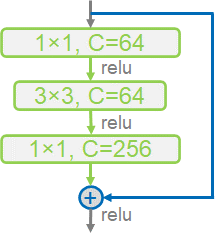

また、重要な特徴表現を獲得するためには、次元数を増加させる必要があります。そのため、ResNetでは一部のレイヤーでダウンサンプリングしてから次元数を増やす処理を行っています。


---
### <font color="Red">ワーク</font>
#### CNNを実装しよう！
3x3のCNNと１x１のCNNを実装して出力を確認してみよう！
以下のサンプルをCNNに入力します。


In [6]:
import torch
import torch.nn as nn

a = torch.rand(256, 3, 6, 6) #  # [バッチサイズ, チャンネル数, 高さ, 幅]
a.size()

torch.Size([256, 3, 6, 6])

1-1. nn.Conv2dを使って、3x3のCNNを定義しよう<br>
※入力の次元数：3, 出力次元数：6, カーネルサイズ: 3x3, ストライド: 1, パディング: 1

In [ ]:
conv3x3 = #########
conv3x3

1-2. CNNにサンプルを入力して結果を確認しよう

In [ ]:
output = ##########
output.size()

1-3. 1-1のCNNのストライドを2に変更したら、出力結果がどのように変化するか確認しよう

In [ ]:
conv3x3_v2 = ##########
output = ##########
output.size()

2-1. nn.Conv2dを使って、1x1のCNNを定義しよう<br>
※入力の次元数：3, 出力次元数：1, カーネルサイズ: 1x1, ストライド: 1

In [19]:
conv1x1 = ##########
conv1x1

2-2. CNNにサンプルを入力して結果を確認しよう

In [ ]:
output = ##########
output.size()

---

### ResNet の実装

TorchVision ライブラリでは、VGG や ResNet など有名なネットワークはすでに実装されていて、手軽に利用できます。  
本演習では理解のために ResNet の Residual Block のみを自ら実装してみましょう。  
また、今回扱う Residual Block は Bottleneck アーキテクチャになります。

* <font color="Red">問1. ResNet の Bottleneck を完成させてください。</font>
  * <font color="Red">問1-1. ダウンサンプリングを行う処理を記述してください。</font>
  * <font color="Red">問1-2. skip connectionを行う処理を記述してください。</font>

【ヒント】
skip connectionは畳み込み層の出力`x`と層をまたいだ`shortcut`を足し合わせる処理です。

In [21]:
class Bottleneck(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        stride=1,
        downsample=False
    ):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(
            input_dim, output_dim,
            kernel_size=1, stride=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.conv2 = nn.Conv2d(
            output_dim, output_dim,
            kernel_size=3, stride=stride,
            padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(output_dim)
        self.conv3 = nn.Conv2d(
            output_dim, output_dim * 4,
            kernel_size=1, stride=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(output_dim * 4)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    input_dim, output_dim * 4,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(output_dim * 4)
            )
        else:
            self.downsample = None

    def forward(self, x):
        shortcut = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.downsample is not None:
            shortcut = ### 問1-1 ###

        x += ### 問1-2 ###
        x = self.relu(x)

        return x

### <font color="Red">ガイド</font>

(問1-1)  
CNN におけるダウンサンプリングとは、入力の特徴量マップを小さくすることを指します。  
この操作はプーリング層やストライドが2以上の畳み込み層によって行われます。

bottleneck アーキテクチャでは、layer の異なる skip connection にて元の入力と畳み込みの結果を足し合わせる際に両者の次元・サイズを合わせるため、ダウンサンプリングを利用します。

ダウンサンプリングは `Bottleneck` クラスのコンストラクタ `__init__()` 内にて `self.downsample` として以下のようにインスタンス化されているため（30行目）、これを利用してダウンサンプリングを行います。

```
self.downsample = nn.Sequential(
    nn.Conv2d( input_dim, output_dim * 4,  kernel_size=1, stride=stride, bias=False ),
    nn.BatchNorm2d(output_dim * 4)
)
```

実際にダウンサンプリングが実行される `forward` メソッドでは入力が `x` として受け取られています。  
これは41行目にて以下のように複製・保存されており、元の入力 `x` は3層からなる畳み込み層に渡されていることに留意してください。

```
shortcut = x.clone()
```

<br>

(問1-2)  
ヒントより、skip connection は畳み込み層の出力と、最初の入力を足し合わせる処理を指します。  
これは bottleneck アーキテクチャの図の青い矢印部分に相当します。

問1-1によって畳み込み層の出力 `x` と最初の入力の次元が合わせられているため、行列の和を求めることが可能です。  
行列の和は python の場合通常の足し算と同様にして算出することができます。



---



上記で実装した Bottleneck を用いて、ResNet50 を実装します。

<font color="Red">問2-1. `layer1`の最初の`Bottleneck`のみ、ダウンサンプリングさせるように宣言しましょう。</font><br>
<font color="Red">問2-2~2-4. 各`layer`の最初の`Bottleneck`のみ、ダウンサンプリングさせるように宣言しましょう。ここでは画像サイズを半分にするために`stride`の指定が必要になります。</font>

In [22]:
# torchvision より実装済みの ResNet50 を呼び出し
model_resnet50 = resnet50(pretrained=False)

# Bottleneck を本演習で実装したものに置き換える
model_resnet50.layer1 = nn.Sequential(
    ### 問2-1 ###
    Bottleneck(256, 64),
    Bottleneck(256, 64)
)
model_resnet50.layer2 = nn.Sequential(
    ### 問2-2 ###
    Bottleneck(512, 128),
    Bottleneck(512, 128),
    Bottleneck(512, 128)
)
model_resnet50.layer3 = nn.Sequential(
    ### 問2-3 ###
    Bottleneck(1024, 256),
    Bottleneck(1024, 256),
    Bottleneck(1024, 256),
    Bottleneck(1024, 256),
    Bottleneck(1024, 256)
)
model_resnet50.layer4 = nn.Sequential(
    ### 問2-4 ###
    Bottleneck(2048, 512),
    Bottleneck(2048, 512)
)

# ResNet50 のアーキテクチャの表示
model_resnet50

/Users/uenokoumare/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/uenokoumare/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1)

### <font color="Red">ガイド</font>

(問2-1~2-4)  
4つの layer から構成される model_resnet50 を読み込み、各 layer ごとに問1で定義した `Bottleneck` クラスを利用したモデルへ置き換えます。   
Plain アーキテクチャによって構成される model_resnet50 を Bottlenek アーキテクチャへと置き換えると、以下のような構造となります。

model_resnet50 の元の構造については「 chapter10 画像処理分野 」の p.36 をご覧ください。

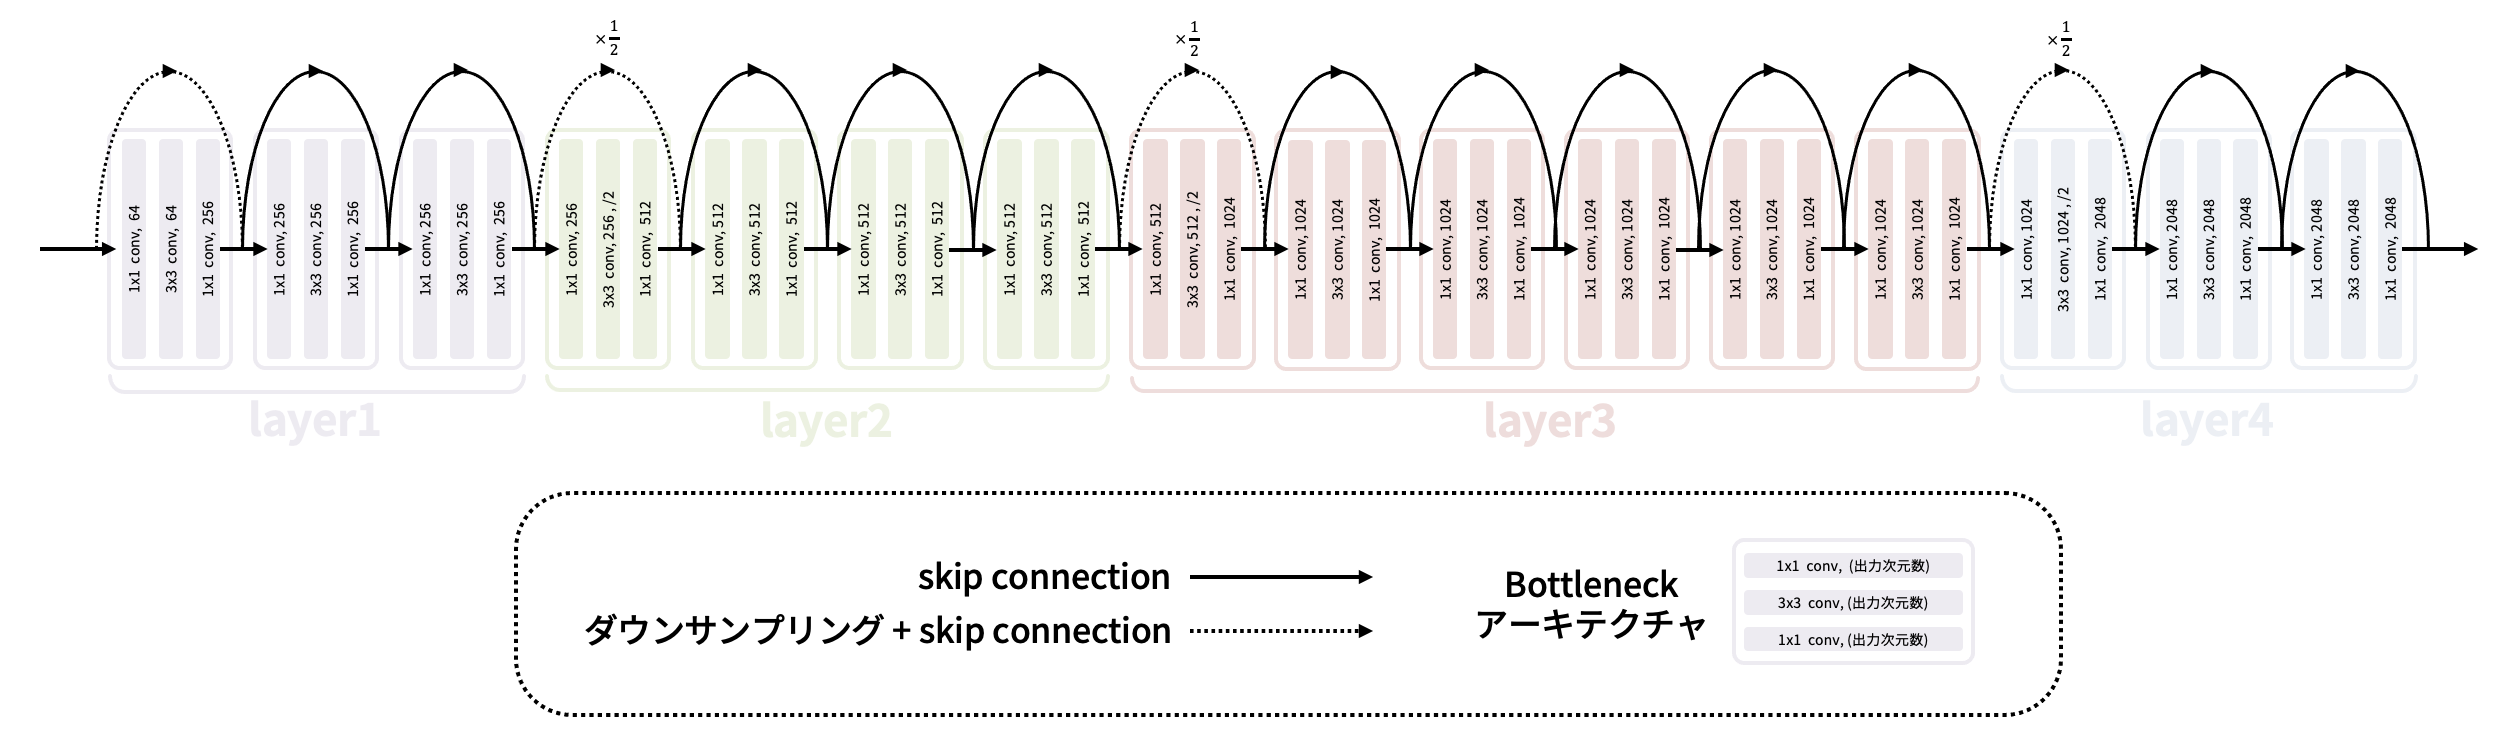

各 layer ごとに数回 Bottleneck アーキテクチャを重ねた構造が見られます。  
コード中では、複数の Bottleneck からなる構造を1つのレイヤーをまとめるために `nn.Sequential()` が利用されています。

以上を踏まえ、各 layer の先頭の  Bottleneck について記述していきます。  
問1コードセルにて定義より、`Bottleneck` クラスの引数は以下の通りです。


```
class Bottleneck():
 - input_dim: 入力次元数
 - output_dim: 出力次元数
 - stride: ストライド （デフォルト： 1）
 - downsample: ダウンサンプリング実行フラグ （デフォルト： False）
```

1. 入力次元数 `input_dim`  
各 layer の先頭の  Bottleneck が受け取る次元数は図の通りとなります。

2. 出力次元数 `output_dim`  
出力次元数は `Bottleneck` が次の`Bottleneck` に渡す値となるため、次の`Bottleneck` の入力次元数 `input_dim`から決定することができます。


ここで `Bottleneck` クラスの `self.conv3` を確認します。

 ```
 self.conv3 = nn.Conv2d( output_dim, output_dim*4, kernel_size=1, stride=1, bias=False )
 ```
このレイヤー以降出力次元数が4倍されており、`Bottleneck` クラスの実際の出力次元数は `output_dim` として指定した値の4倍となります。  
これを踏まえ、設定したい出力次元数を補正する必要があることに注意してください。

3. ストライド `stride`  
畳み込む際にカーネルを動かす量であり、大きくするほど畳み込み後のデータは小さくなります。  
ResNet50 の構造より、先頭 layer 以外では画像サイズを半分とする処理を行なっていることがわかるため、それを根拠として設定することができます。


4. ダウンサンプリング実行フラグ `downsample`  
ダウンサンプリングを実行するように指定してください。

以上の手順によって各 Bottleneck に渡す値を決定することが可能です。

### Fine-tuning

ResNet では、Fine-tunig を行います。

Fine-tunig とは、事前学習で得られたパラメータを再利用する学習方法です。

まずは、torchvision で配布されている事前学習パラメータを読み込みます。

こちらのコードは問2が誤っている場合、エラーが発生します。

In [23]:
state_dict = torch.hub.load_state_dict_from_url("https://download.pytorch.org/models/resnet50-0676ba61.pth", progress=True)
model_resnet50.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

torchvision に実装されている ResNet50 の出力層は 1000クラスを分類するようになっています。  
しかし、本演習では飛行機と自動車の 2クラス分類のため出力層を追加する必要があります。

<font color="Red">問3. 2クラス分類を行うために出力層を変更してください。出力サイズは`2`とします。</font>

【ヒント】

`feat_dim = model_resnet50.fc.in_features` では出力層の入力の次元数を取得しています。

In [25]:
feat_dim = model_resnet50.fc.in_features
model_resnet50.fc = #### 問3 ####

### <font color="Red">ガイド</font>

(問3)  
まず model_resnet50 の構造を確認します。

In [26]:
# torchvision より実装済みの ResNet50 を呼び出し
model_resnet50 = resnet50(pretrained=False)  # 問2コードセル2行目

model_resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

model_resnet50 の最終層が fc という名称の全結合層 Linear であり、入力次元数 `2048`、出力次元数 `1000` であることがわかります。  
この model_resnet50 は 1000クラス分類を想定したモデルであるため、出力次元数が `1000` となっています。

層の名称が判明したため、以降は名称から層を呼び出すことが可能です。

In [27]:
model_resnet50.fc

Linear(in_features=2048, out_features=1000, bias=True)

この `model_resnet50.fc` を 2 クラス分類のためのモデルへ書き換えます。  

まず最終層は全結合層となるため、`nn.Linear()` を利用して全結合層を用意します。  
`nn.Linear()` に与えるべき引数は以下の通りです。
```
nn.Linear(in_features, out_features):
 - in_features: 入力次元数
 - out_features: 出力次元数
```

1. 入力次元数 `in_features`  
層の入力次元数は直前の層の出力次元数となります。  
すなわち層 `fc` の受け取る次元数は書き換えの影響を受けず、同一のものとなります。  
ヒントより、今回は以下のコードによって層 `fc` が受けとっていた次元数が `feat_dim` として保存されています。
```
feat_dim = model_resnet50.fc.in_features
```

2. 出力次元数 `out_features`  
分類モデルの最終層となる全結合層の出力次元数は、分類するクラスの数によって決定されます。  
また、本問題では2クラス分類を扱うことが定められています。

<br>

（別解）  
2クラス分類は「クラスAとBのどちらに属するか」だけでなく、「クラスAであるか否か」と解釈することも可能です。  
この場合、出力次元数 `units` と活性化関数 `activation`は先ほどの設定と異なるものとなります。  

活性化関数については入力を0〜1に納めるシグモイド関数が利用され、モデルの出力値を「そのクラスである確率」へと変換します。

---



モデルの全てのパラメータを学習によって最適化します。

<font color="Red">問4. 学習率`lr=0.001`, モーメンタム`momentum=0.9`で最適化アルゴリズム`SGD`を完成させてください。</font>

【ヒント】

`model_resnet50`の全てのパラメータを`torch.optim.SGD`の引数に与えます。

In [28]:
# optimizer
optimizer = ### 問4 ###

# 損失関数
loss_fn = nn.CrossEntropyLoss()

### <font color="Red">ガイド</font>

(問4)  
最適化アルゴリズム SDG は関数 `torch.optim.SGD()` によって使用することができます。  
今回 `torch.optim.SGD()` へ与えるべき引数は以下の通りです。
```
torch.optim.SGD(params, lr, momentum):
 - params: 最適化を行うパラメータ
 - lr: 学習率
 - momentum: モーメンタム
```

1. 最適化を行うパラメータ `params`  
最適化の対象である model_resnet50 のパラメータを取得します。  
層のパラメータの取得には `.parameters()` メソッドを利用することができます。  
これにより事前学習パラメータを利用して学習を行う Fine-tunig を行います。


2. 学習率 `lr`  
3. モーメンタム `momentum`  

2と3については設問中で具体的な値が指定がされています。



---



### 学習

５エポックで精度が80%以上になっていれば学習成功です。

学習には、GPU環境で2~3分ほどかかります。

In [29]:
model_resnet50.to(device)

for epoch in range(5):
    print("Epoch: {}".format(epoch + 1))

    model_resnet50.train()
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_resnet50(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch + 1 in [2, 5]:
        model_resnet50.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for inputs, labels in tqdm(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model_resnet50(inputs)
                _, preds = torch.max(outputs, 1)

                total += inputs.size(0)
                correct += torch.sum(preds == labels.data)
        print("認識精度: {}".format(100 * (correct / total)))

Epoch: 1


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

認識精度: 69.8499984741211
Epoch: 3


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

認識精度: 74.0999984741211



## 2. WideResNetを用いたCIFAR10の分類

### WideResNetについて

WideResNetは、ResNetの層数を減らし各層の次元数を増加させることで精度を向上させるネットワークになっています。

このような変更を加えたメリットとして以下が挙げられます。
- 次元数を増やすことで、層数が少なくても十分な特徴表現を獲得できる。
- 畳み込み層は、次元数が増えたとしても並列計算できるためあまりの計算コストが増加しない。WideResNetではその分層数を減らしているため、より計算コストを削減することができる。

また、層を深くしたWideResNetでは畳み込み層の間にDropoutを用いることで、精度が向上することも報告されている。

### bottleneckのアーキテクチャ

WideResNetのbottleneckとResnetのbottleneckの違いは、畳み込み層の2層目の次元数をk倍している部分です。

以下の図の例では、`k=2`を採用しています。

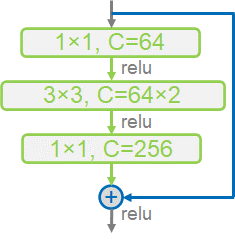


---
### <font color="Red">ワーク</font>
#### CNNの次元数を操作してみよう！

以下のサンプルをCNNに入力します。

In [30]:
import torch
import torch.nn as nn

a = torch.rand(256, 3, 6, 6) # [バッチサイズ, チャンネル数, 高さ, 幅]
a.size()

torch.Size([256, 3, 6, 6])

前回のワークでは、`Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))`のCNNを用いました。このCNNをWideResNetのように次元数をk倍してみましょう！<br>

1-1. ここでは次元数をk倍したCNNを定義しよう

In [31]:
# 前回のワークのCNN
# conv3x3 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1)

k = 2

wide_conv2d = ##########

1-2. CNNにサンプルを入力して結果を確認しよう

In [ ]:
output = ##########
output.size()

---

### WideResNet の実装

ResNet に引き続き、WideResNet も Residual Block のみを自ら実装してみましょう。  
ResNet 同様、Residual Block は Bottleneck アーキテクチャになります。

* <font color="Red">問5. WideResNet の Bottleneck を完成させてください。</font>
  * <font color="Red">問5-1. ダウンサンプリングを行う処理を記述してください。</font>
  * <font color="Red">問5-2. skip connectionを行う処理を記述してください。</font>

【ヒント】
skip connectionは畳み込み層の出力`x`と層をまたいだ`shortcut`を足し合わせる処理です。

In [33]:
class WideBottleneck(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        stride=1,
        downsample=False
    ):
        super(WideBottleneck, self).__init__()

        hidden_dim = output_dim * 2

        self.conv1 = nn.Conv2d(
            input_dim, hidden_dim,
            kernel_size=1, stride=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.conv2 = nn.Conv2d(
            hidden_dim, hidden_dim,
            kernel_size=3, stride=stride,
            padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(hidden_dim)
        self.conv3 = nn.Conv2d(
            hidden_dim, output_dim * 4,
            kernel_size=1, stride=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(output_dim * 4)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    input_dim, output_dim * 4,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(output_dim * 4)
            )
        else:
            self.downsample = None

    def forward(self, x):
        shortcut = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.downsample is not None:
            shortcut = ### 問5-1 ###

        x += ### 問5-2 ###
        x = self.relu(x)

        return x

### <font color="Red">ガイド</font>

(問5-1, 問5-2)  
問1で定義した `Bottleneck` と問5にて定義する `WideBottleneck` の違いは、畳み込み層の2層目の次元数を k 倍する処理です。  
WideResNet の bottleneck アーキテクチャの項目にて、今回は k を`2`と定めていることがわかります。

この処理は問5コードセル11行目にて以下のように記述されています。

```
hidden_dim = output_dim * 2
```

以上の部分以外について `Bottleneck`と `WideBottleneck` の間に大きな差はないため、問1のガイドと同様にして解くことが可能です。



---



上記で実装した Bottleneck を用いて、WideResNet50 を実装します。

<font color="Red">問6-1. `layer1`の最初の`Bottleneck`のみ、ダウンサンプリングさせるように宣言しましょう。</font><br>
<font color="Red">問6-2~6-4. 各`layer`の最初の`Bottleneck`のみ、ダウンサンプリングさせるように宣言しましょう。ここでは画像サイズを半分にするために`stride`の指定が必要になります。</font>

In [ ]:
# torchvision より実装済みの WideResNet50 を呼び出し
model_wide_resnet50 = wide_resnet50_2(pretrained=False)

# Bottleneck を本演習で実装したものに置き換える
model_wide_resnet50.layer1 = nn.Sequential(
    ### 問6-1 ###
    WideBottleneck(256, 64),
    WideBottleneck(256, 64)
)
model_wide_resnet50.layer2 = nn.Sequential(
    ### 問6-2 ###
    WideBottleneck(512, 128),
    WideBottleneck(512, 128),
    WideBottleneck(512, 128)
)
model_wide_resnet50.layer3 = nn.Sequential(
    ### 問6-3 ###
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256),
    WideBottleneck(1024, 256)
)
model_wide_resnet50.layer4 = nn.Sequential(
    ### 問6-4 ###
    WideBottleneck(2048, 512),
    WideBottleneck(2048, 512)
)

# WideResNet50 のアーキテクチャの表示
model_wide_resnet50

### <font color="Red">ガイド</font>

(問6-1~6-4)  
問2のガイドと同様にして解くことが可能です。  
このとき、`Bottleneck` ではなく `WideBottleneck`を利用することに注意してください。

ここで WideResNet50 は以下のような構造となっています。



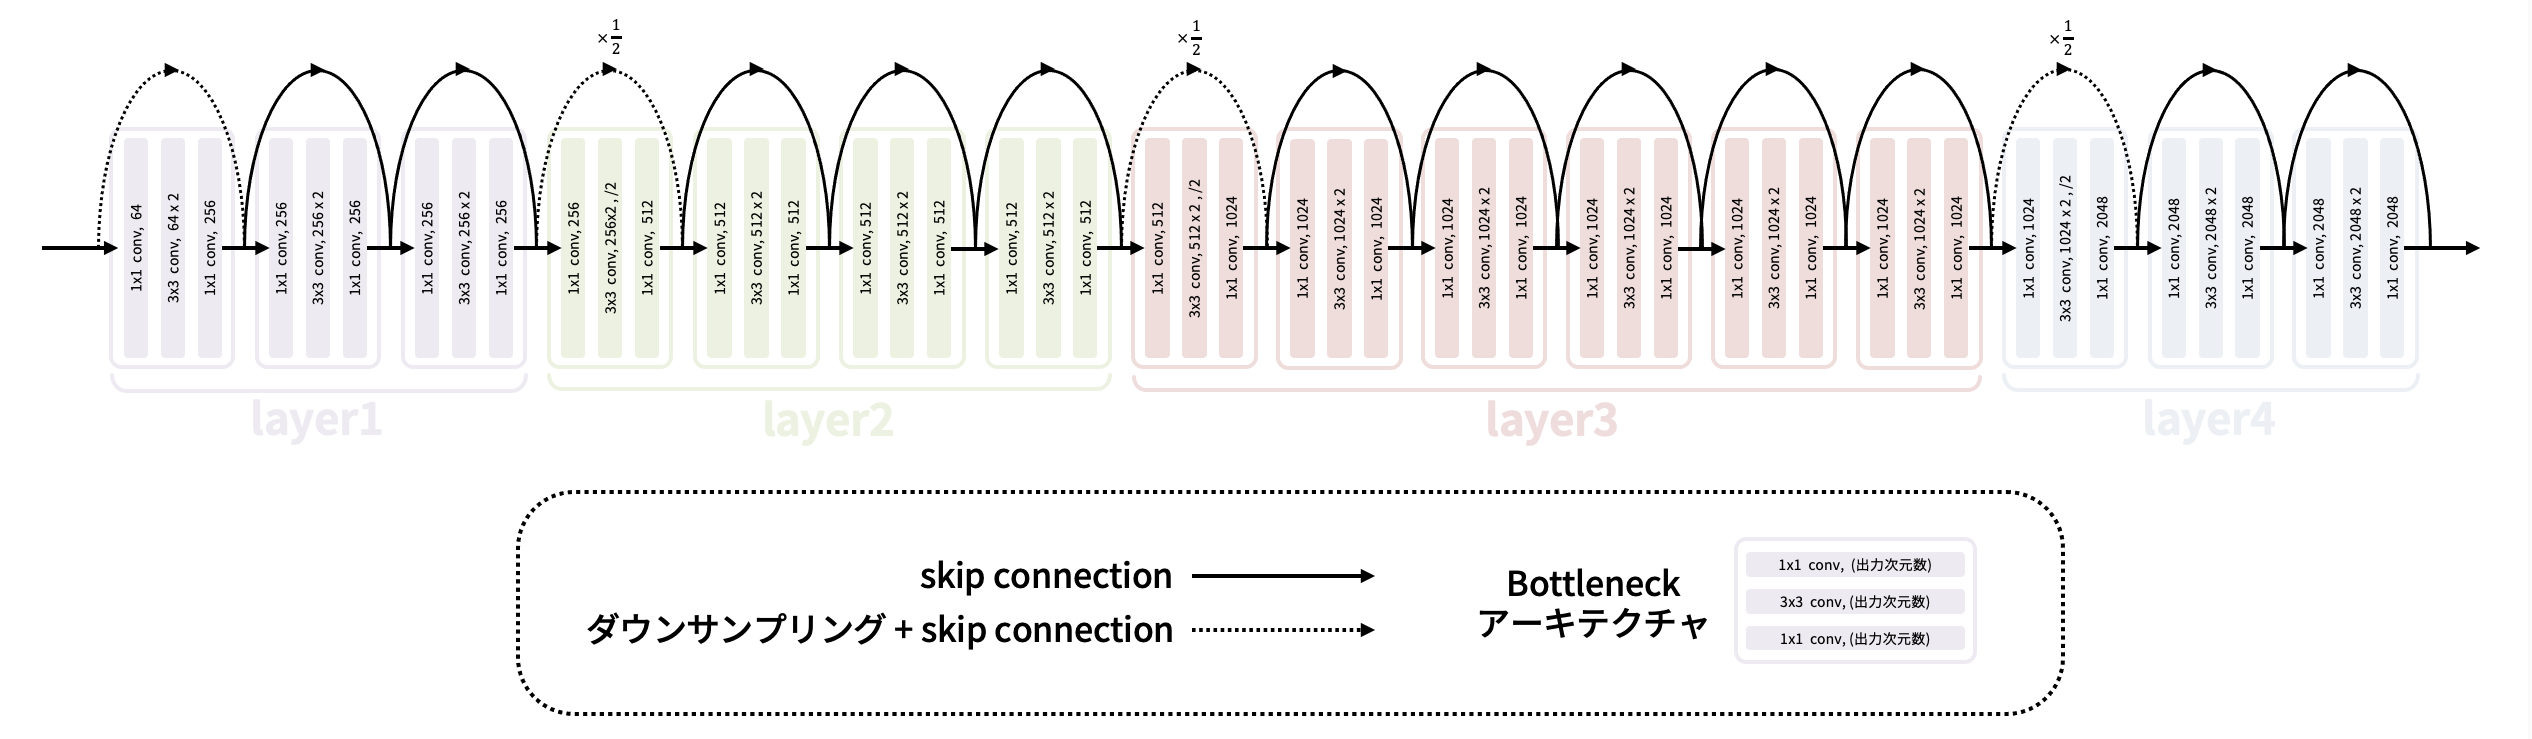

---

### 転移学習

WideResNet では、転移学習を行います。

転移学習とは、事前学習で得られたパラメータを固定し、新たに追加した層のみを学習する手法です。

まずは、torchvision で配布されている事前学習パラメータを読み込みます。

In [35]:
state_dict = torch.hub.load_state_dict_from_url("https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth", progress=True)
model_wide_resnet50.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

次に、事前学習されたパラメータを固定します。  
固定されたパラメータは学習されません。

<font color="Red">問7. 事前学習で使用されたモデルパラメータを固定する処理を完成させてください。</font>

In [36]:
for param in model_wide_resnet50.parameters():
    param.requires_grad = #### 問7 ####

### <font color="Red">ガイド</font>
1行目では、モデル `model_wide_resnet50` の全パラメータを変数 `param` として順番に全て取り出しています。  

取り出されたパラメータ `param` の勾配計算の設定は `.requires_grad` 属性によって決定されます。  
`.requires_grad` 属性はデフォルトで `True` を持ち、そのパラメータの勾配計算を行う状態として設定されているため、これを書き換えましょう。



---

さらに、2クラス分類に2クラス分類のため出力層を追加しましょう。

<font color="Red">問8. 2クラス分類を行うために出力層を追加してください。</font>

In [37]:
feat_dim = model_wide_resnet50.fc.in_features
model_wide_resnet50.fc = #### 問8（問3と同じ）####

### <font color="Red">ガイド</font>

(問8)  
問3と同様にして解くことが可能です。


---



<font color="Red">問9. 学習率`lr=0.001`, モーメンタム`momentum=0.9`で最適化アルゴリズム`SGD`を完成させてください。</font>

In [38]:
# optimizer
optimizer = ### 問9 ###

# 損失関数
loss_fn = nn.CrossEntropyLoss()

### <font color="Red">ガイド</font>

(問9)  
問4と同様にして解くことが可能ですが、事前学習の結果を用いて最適化を行う Fine-tuning と異なり、転移学習では新たに追加した層のみ学習を行うことに注意してください。

問8より先ほど追加した出力層の名称は `fc` であり、以下のように層の名称を利用してモデルから特定の層のみ呼び出すことが可能です。
```
model_resnet50.fc     # model_resnet50 の層 fc を呼び出し
```

---



### 学習

５エポックで精度が80%以上になっていれば学習成功です。

学習には、GPU環境で15~20分ほどかかります。

GPU環境でない場合、学習にかなりの時間が必要になると思われます。  
Google ColabのGPU環境で実行することを推奨します。

In [39]:
model_wide_resnet50.to(device)

for epoch in range(5):
    print("Epoch: {}".format(epoch + 1))

    model_wide_resnet50.train()
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_wide_resnet50(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch + 1 in [2, 5]:
        model_wide_resnet50.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for inputs, labels in tqdm(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model_wide_resnet50(inputs)
                _, preds = torch.max(outputs, 1)

                total += inputs.size(0)
                correct += torch.sum(preds == labels.data)
        print("認識精度: {}".format(100 * (correct / total)))

Epoch: 1


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

認識精度: 91.44999694824219
Epoch: 3


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

認識精度: 89.85000610351562
